In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import datetime, timedelta

In [106]:
InvestmentTime = 30
StartDate = datetime.today() - timedelta(days=InvestmentTime*365)
EndDate = datetime.today().strftime('%Y-%m-%d')

sp_df = yf.download('^GSPC',start=StartDate, end=EndDate, progress=False)
aapl_df = yf.download('AAPL',start=StartDate, end=EndDate, progress=False)
ibm_df = yf.download('IBM',start=StartDate, end=EndDate, progress=False)
amzn_df =yf.download('AMZN',start=StartDate, end=EndDate, progress=False)

portfolio = pd.concat([sp_df['Close'], aapl_df['Close'], ibm_df['Close'], amzn_df['Close']], axis=1)
portfolio.columns = ['SP500', 'Apple', 'IBM', 'Amazon']
portfolio.head()

,SP500,Apple,IBM,Amazon
Date,,,,
1991-07-31,387.809998,0.412946,25.31250,NaN
1991-08-01,387.119995,0.438616,25.31250,NaN
1991-08-02,387.179993,0.446429,25.09375,NaN
1991-08-05,385.059998,0.433036,25.25000,NaN
1991-08-06,390.619995,0.441964,25.09375,NaN


<AxesSubplot:xlabel='Date'>

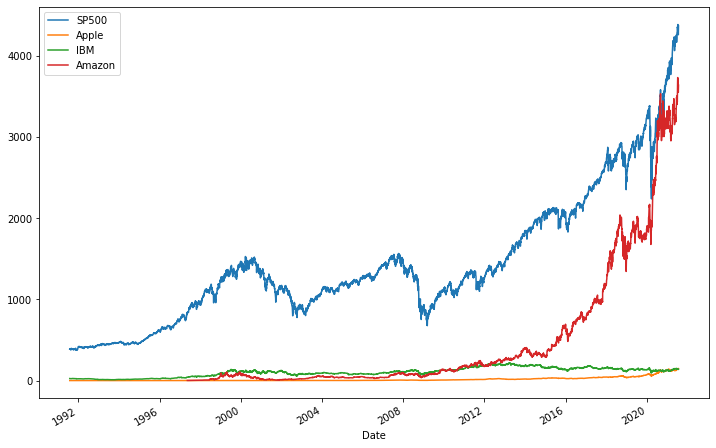

In [116]:
portfolio.plot(figsize=(12,8))

In [108]:
# Logarithmic daily return
portfolio_log_daily_ret = np.log(portfolio/portfolio.shift(1))
portfolio_log_daily_ret.head()

,SP500,Apple,IBM,Amazon
Date,,,,
1991-07-31,NaN,NaN,NaN,NaN
1991-08-01,-0.001781,0.060308,0.000000,NaN
1991-08-02,0.000155,0.017656,-0.008680,NaN
1991-08-05,-0.005491,-0.030460,0.006207,NaN
1991-08-06,0.014336,0.020408,-0.006207,NaN


array([[<AxesSubplot:title={'center':'SP500'}>,
        <AxesSubplot:title={'center':'Apple'}>],
       [<AxesSubplot:title={'center':'IBM'}>,
        <AxesSubplot:title={'center':'Amazon'}>]], dtype=object)

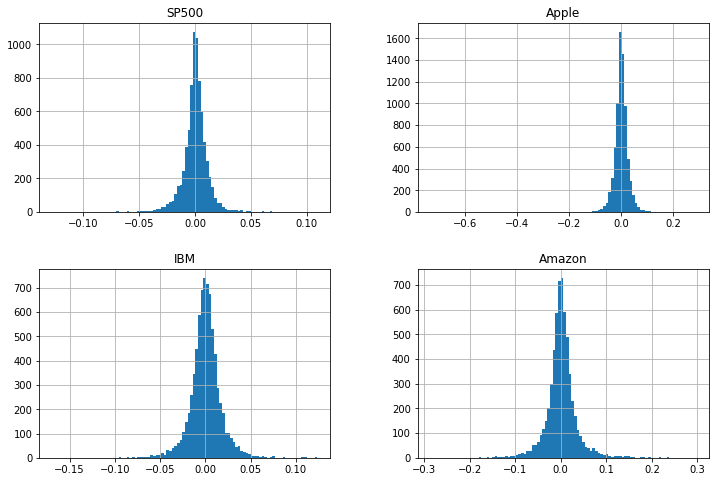

In [109]:
portfolio_log_daily_ret.hist(bins=100, figsize=(12,8))

In [110]:
print(stocks.columns)

np.random.seed(101)
weights = np.array(np.random.random(4))
weights = weights/(np.sum(weights))

print("Random Allocation")
print(weights)

Index(['SP500', 'Apple', 'IBM', 'Amazon'], dtype='object')
Random Allocation
[0.40122278 0.44338777 0.02212343 0.13326603]


In [111]:
# Optimal allocation of the portfolio
from scipy.optimize import minimize

# define a couple of functions
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(portfolio_log_daily_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(portfolio_log_daily_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharp(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    # return 0 if the sum of the weights is one
    return np.sum(weights) - 1

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [112]:
cons = ({"type":"eq", "fun":check_sum})
bounds = tuple([(0,1)] * len(portfolio_log_daily_ret.columns))
init_guess = [1/len(portfolio_log_daily_ret.columns) for i in range(len(portfolio_log_daily_ret.columns))] 
opt_results = minimize(neg_sharp, init_guess, method='SLSQP', bounds=bounds, constraints=cons)


Optimal Allocation:
('SP500', 0.3524882560553695)
('Apple', 0.2910954972222244)
('IBM', 5.9631119486702744e-18)
('Amazon', 0.3564162467224063)

Optimal ret/vol/sr:
[0.19662902 0.31572058 0.62279445]


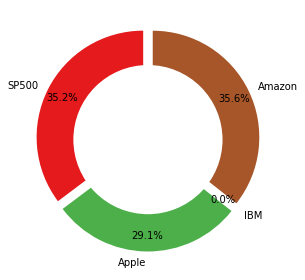

In [167]:
print('\nOptimal Allocation:')
for optw in zip(portfolio.columns, opt_results.x):
    print(optw)

print('\nOptimal ret/vol/sr:')
optimal_results = get_ret_vol_sr(opt_results.x)
print(optimal_results)

from matplotlib import cm


colors = cm.Set1(np.arange(len(opt_results.x))/len(opt_results.x))
explode = [0.05 for i in range(0,len(opt_results.x))]

plt.pie(opt_results.x, labels=portfolio.columns, colors=colors, autopct='%1.1f%%',
        startangle=90, pctdistance=0.85, explode=explode)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

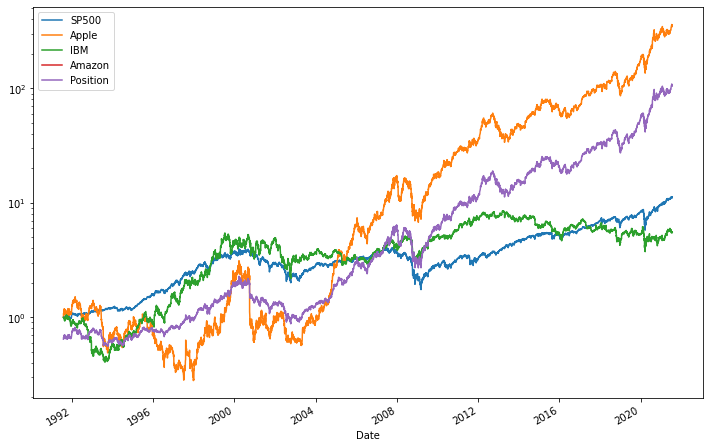

In [163]:
# Benchmarking the portfolio
for name in portfolio.columns:
    portfolioNormedReturn[name] = portfolio[name] / portfolio.iloc[0][name]

# Quick fix
if 'Position' in portfolioNormedReturn.columns:
    portfolioNormedReturn = portfolioNormedReturn.drop(columns=['Position'], axis=1)

# Sum the columns with the weights in Position column
portfolioNormedReturn['Position'] = portfolioNormedReturn[portfolioNormedReturn.columns].mul(opt_results.x).sum(axis=1)

for col in portfolioNormedReturn.columns:
    portfolioNormedReturn[col] = portfolioNormedReturn[col]
    
portfolioNormedReturn.plot(figsize=(12,8))
plt.yscale("log")